# 🧪 Laboratorio 7
Integrantes
- Diego Alexander Hernández Silvestre - 21270
- Linda Inés Jiménez Vides - 21169
- Mario Antonio Guerra Morales - 21008
- Kristopher Javier Alvarado López - 21188

## 💻 Task 1

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import imageio
from IPython.display import Image, display

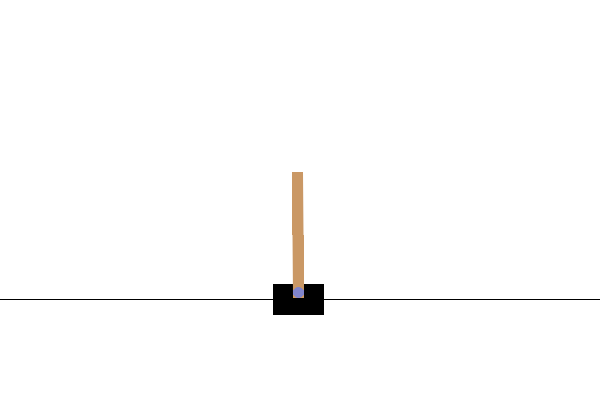

In [2]:


# Crear el entorno CartPole
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Reiniciar el entorno
state, info = env.reset()

# Lista para almacenar los frames
frames = []

# Número de pasos máximos a ejecutar
num_steps = 500

# Loop para ejecutar los pasos en el entorno
for step in range(num_steps):
    # Renderizar el entorno y capturar el frame
    frame = env.render()
    frames.append(frame)

    # Seleccionar una acción: hacia la derecha si el ángulo del poste es negativo, izquierda si es positivo
    action = 0 if state[2] < 0 else 1  # Política simple basada en el ángulo del poste
    
    # Realizar la acción en el entorno
    next_state, reward, done, truncated, info = env.step(action)
    
    # Si el episodio ha terminado, reiniciar el entorno
    if done or truncated:
        state, info = env.reset()
    else:
        state = next_state

# Cerrar el entorno
env.close()

# Guardar el GIF en un archivo
gif_filename = 'data/cartpole_simulation.gif'
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Mostrar el GIF en la celda
display(Image(filename=gif_filename))


In [3]:


env = gym.make("CartPole-v1")

def Random_games():
    # Each of this episode is its own game.
    for episode in range(10):
        env.reset()
        # this is each frame, up to 500...but we wont make it that far with random.
        for t in range(500):
            # This will display the environment
            # Only display if you really want to see it.
            # Takes much longer to display it.
            env.render()
            
            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()

            # this executes the environment with an action, 
            # and returns the observation of the environment, 
            # the reward, if the env is over, and other info.
            next_state, reward, done, truncated, info = env.step(action)
            
            # lets print everything in one line:
            print(t, next_state, reward, done, truncated, info, action)
            if done or truncated:
                break
                
Random_games()

0 [ 0.02167965 -0.18088427  0.04059044  0.30985576] 1.0 False False {} 0
1 [ 0.01806197 -0.37656033  0.04678756  0.6150584 ] 1.0 False False {} 0
2 [ 0.01053076 -0.18212228  0.05908873  0.337471  ] 1.0 False False {} 1
3 [0.00688832 0.01211123 0.06583815 0.06399121] 1.0 False False {} 1
4 [ 0.00713054 -0.18388987  0.06711797  0.37669832] 1.0 False False {} 0
5 [ 0.00345275 -0.3798977   0.07465194  0.689766  ] 1.0 False False {} 0
6 [-0.00414521 -0.5759719   0.08844726  1.0049853 ] 1.0 False False {} 0
7 [-0.01566465 -0.77215666  0.10854696  1.3240818 ] 1.0 False False {} 0
8 [-0.03110778 -0.96846926  0.1350286   1.6486678 ] 1.0 False False {} 0
9 [-0.05047717 -0.7751597   0.16800195  1.4009207 ] 1.0 False False {} 1
10 [-0.06598036 -0.97192323  0.19602038  1.7410712 ] 1.0 False False {} 0
11 [-0.08541882 -1.1686629   0.2308418   2.0877907 ] 1.0 True False {} 0
0 [ 0.00895482  0.21396764 -0.00484436 -0.26401886] 1.0 False False {} 1
1 [ 0.01323417  0.4091584  -0.01012474 -0.5582258 ] 1.

c:\Users\Alvar\OneDrive\Documentos\SemestreVIII\Deep Learning\Lab07_DL\myenv\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [4]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Definir redes
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
online_net = QNetwork(input_dim, output_dim)
target_net = QNetwork(input_dim, output_dim)

# Inicializar pesos de la red de destino con los de la red en línea
target_net.load_state_dict(online_net.state_dict())


<All keys matched successfully>

In [5]:
# Definición de hiperparámetros
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Parámetro de exploración inicial
epsilon_decay = 0.995  # Decaimiento de epsilon
epsilon_min = 0.01  # Valor mínimo de epsilon
lr = 0.001  # Tasa de aprendizaje
batch_size = 64  # Tamaño del batch
memory_size = 10000  # Tamaño de la memoria de experiencia
target_update_freq = 10  # Frecuencia de actualización de la red de destino


In [6]:
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Exploración
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = online_net(state)
        return torch.argmax(q_values).item()  # Explotación

In [7]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones))

replay_buffer = ReplayBuffer(memory_size)

In [15]:
# Ciclo de entrenamiento

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(online_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Número de episodios y pasos máximos por episodio
num_episodes = 1000
max_timesteps = 500

# Lista para almacenar las recompensas totales por episodio
total_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        # Seleccionar una acción usando la política epsilon-greedy
        action = epsilon_greedy_action(state, epsilon)
        
        # Ejecutar la acción en el entorno
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        
        # Almacenar la experiencia en el buffer de reproducción
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Actualizar el estado actual
        state = next_state
        
        # Si hay suficientes muestras en el buffer, realizar una actualización
        if len(replay_buffer.buffer) >= batch_size:
            # Muestrear un batch de experiencias
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Convertir a tensores de PyTorch
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)
            
            # Calcular los valores Q actuales
            q_values = online_net(states).gather(1, actions).squeeze(1)
            
            # Calcular los valores Q objetivo usando la red de destino
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values * (1 - dones)
            
            # Calcular la pérdida
            loss = loss_fn(q_values, targets)
            
            # Retropropagación y actualización de pesos
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Si el episodio ha terminado, salir del loop
        if done or truncated:
            break
    
    # Almacenar la recompensa total obtenida en este episodio
    total_rewards.append(total_reward)
    
    # Decaimiento de epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    else:
        epsilon = epsilon_min
    
    # Actualizar la red de destino cada 'target_update_freq' episodios
    if episode % target_update_freq == 0:
        target_net.load_state_dict(online_net.state_dict())
    
    # Imprimir el progreso
    print(f"Episodio {episode}, Recompensa Total: {total_reward}, Epsilon: {epsilon:.4f}")



Episodio 0, Recompensa Total: 12.0, Epsilon: 0.9950
Episodio 1, Recompensa Total: 10.0, Epsilon: 0.9900
Episodio 2, Recompensa Total: 16.0, Epsilon: 0.9851
Episodio 3, Recompensa Total: 13.0, Epsilon: 0.9801
Episodio 4, Recompensa Total: 16.0, Epsilon: 0.9752
Episodio 5, Recompensa Total: 16.0, Epsilon: 0.9704
Episodio 6, Recompensa Total: 16.0, Epsilon: 0.9655
Episodio 7, Recompensa Total: 13.0, Epsilon: 0.9607
Episodio 8, Recompensa Total: 36.0, Epsilon: 0.9559
Episodio 9, Recompensa Total: 14.0, Epsilon: 0.9511
Episodio 10, Recompensa Total: 27.0, Epsilon: 0.9464
Episodio 11, Recompensa Total: 28.0, Epsilon: 0.9416
Episodio 12, Recompensa Total: 27.0, Epsilon: 0.9369
Episodio 13, Recompensa Total: 16.0, Epsilon: 0.9322
Episodio 14, Recompensa Total: 13.0, Epsilon: 0.9276
Episodio 15, Recompensa Total: 43.0, Epsilon: 0.9229
Episodio 16, Recompensa Total: 30.0, Epsilon: 0.9183
Episodio 17, Recompensa Total: 43.0, Epsilon: 0.9137
Episodio 18, Recompensa Total: 13.0, Epsilon: 0.9092
Epi

In [14]:
# Representar el entorno

In [10]:
# Supervisar el entrenamiento

In [11]:
# Evalúe el rendimiento

In [12]:
# Fine-Tuning

## 💻 Task 2

### Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en Deep Reinforcement Learning:

**1. Proximal Policy Optimization**
* Respuesta

**2. Deep Deterministic Policy Gradients (DDPG)**
* Respuesta

**3. Trust Region Policy Optimization (TRPO)**
* Respuesta

**4. Asynchronous Advantage Actor-Critic (A3C)**
* Respuesta